In [1]:
using Pkg
Pkg.activate("..")
Pkg.status()

  Activating project at `c:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS437B\dmrg`


Status `C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS437B\dmrg\Project.toml`
  [336ed68f] CSV v0.10.14
  [a93c6f00] DataFrames v1.6.1
  [7a1cc6ca] FFTW v1.8.0
⌃ [28b8d3ca] GR v0.73.5
⌃ [86223c79] Graphs v1.11.0
  [f67ccb44] HDF5 v0.17.2
⌅ [2919e153] ITensorNetworks v0.9.0
⌅ [9136182c] ITensors v0.4.1
  [c8e1da08] IterTools v1.10.0
  [4138dd39] JLD v0.13.5
  [2c470bb0] Kronecker v0.5.5
⌅ [0b1a1467] KrylovKit v0.7.1
  [b964fa9f] LaTeXStrings v1.3.1
  [2fda8390] LsqFit v0.15.0
  [9663349c] MathieuFunctions v1.2.0
  [338f10d5] Observers v0.2.5
  [f0f68f2c] PlotlyJS v0.18.13
⌃ [91a5bcdd] Plots v1.40.4
⌃ [f27b6e38] Polynomials v4.0.8
  [1fd47b50] QuadGK v2.9.4
⌅ [0c5d862f] Symbolics v5.14.1
  [6aa20fa7] TensorOperations v4.1.1
  [98f94333] Tensorial v0.14.1
  [9d95972d] TupleTools v1.5.0
⌃ [ddb6d928] YAML v0.4.10
  [8603256b] ZChop v0.3.11
Info Packages marked with ⌃ and ⌅ have new versions available, but those with ⌅ are restricted by compatibility constraints from upg

In [2]:
using ITensors
using ITensorNetworks
using Observers
using Printf
using HDF5
using LinearAlgebra
import Random
	
function compute_timestep(psi, H; Nstd=3, freq_multiple=8)
	if H isa TTN
		Hpsi = apply(H, psi; init=psi, nsweeps=3)
	else
		Hpsi = apply(H, psi)
	end
	H_ex = inner(psi, Hpsi)
	# @show H_ex
	H2_ex = inner(Hpsi, Hpsi)
	# @show sqrt(H2_ex - H_ex^2)
	peak_energy = freq_multiple*(abs(H_ex) + Nstd*sqrt(H2_ex - H_ex^2))
	return 2π/peak_energy
end

function apply_elementwise_projector(matrix, sites, state; parity="even")
    tmp = copy(state)
    for i in eachindex(sites)
        tmp = apply(op(matrix,sites[i]),tmp)
    end
    if parity == "even"
        return (tmp + state)/2
    end
    return (state - tmp)/2
end


include("input_data.jl")
include("matrices.jl")
include("states.jl")
include("expectations.jl")
include("dvr.jl")
include("utility_funcs.jl")


total_memory_usage (generic function with 1 method)

In [3]:
Nspec, Nsites, Nbonds, Nsweep, e_cutoff, 
		SVD_error, gstart, delta_g, Ng,
        mbond, pairs, evod, angle, Estrength, 
		Nstates, output_filename, parity_symmetry_type,
		inversion_symmetry_type = get_input_data("input_quick.yml"; default_filename="psi0_N6_g")

###{tdvp_filename}.h5 will be where the data is stored (written to on the fly while propagating every 5th sweep by default)
###ToDo: we might want to parse the name for that file from input

use_inversion_symmetry = inversion_symmetry_type == "even" || inversion_symmetry_type == "odd"
use_parity_symmetry = parity_symmetry_type == "even" || parity_symmetry_type == "odd"

#Calculate kinetic matrix and x operator#
Ttmp = kinetic(Nspec)
Xtmp = Xoperator(Nspec)
Ytmp = Yoperator(Nspec)
Uptmp = Upoperator(Nspec)
Downtmp = Downoperator(Nspec)

if evod == "dvr"
	symmetry = trivial_symmetry
	if use_inversion_symmetry && use_parity_symmetry
		symmetry = dvr_symmetric_basis
	elseif use_inversion_symmetry
		symmetry = dvr_inversion_symmetry
	elseif use_parity_symmetry
		symmetry = dvr_rotation_symmetry
	end

	# define basis
	tmp1,tmp2,tmp3 = symmetry.(exp_dvr(Nspec))
	global T = tmp1
	global X = tmp2
	global Y = tmp3
end
if evod == "m"
    symmetry = trivial_symmetry
	if use_inversion_symmetry && use_parity_symmetry
		symmetry = x -> parity_symmetry(m_inversion_symmetry(x))
	elseif use_inversion_symmetry
		symmetry = m_inversion_symmetry
	elseif use_parity_symmetry
		symmetry = parity_symmetry
	end


	# define basis
	global T = symmetry(Ttmp)
	global X = symmetry(Xtmp)
	global Y = symmetry(Ytmp)
	global Up = symmetry(Uptmp)
	global Down = symmetry(Downtmp)
end
include("operators.jl")
include("observer.jl")

g = 1.1

tdvp_filename = string("tdvp_logs/", output_filename,string(round(g,digits=3)))
dmrg_filename = string("dmrg_logs/", output_filename,string(round(g,digits=3)))

sites = siteinds("PlaRotor",Nsites;basis=evod,dim=Nspec, conserve_parity=use_parity_symmetry, conserve_inversion_symmetry=use_inversion_symmetry)
# sites = siteinds("PlaRotor",Nsites;basis=evod,dim=Nspec, conserve_parity=false, conserve_inversion_symmetry=false)

Random.seed!(1234)
psit0 = generate_initial_state(sites; parity_symmetry_type, inversion_symmetry_type)
# psit0 = generate_initial_state(sites)
@show flux(psit0)

# sites = siteinds(psi)

@show hasqns.(sites)
H, ampo = create_Hamiltonian(g, sites, "nearest"; evod=evod, get_ampo=true)


# psit0 = apply_elementwise_projector(symmetry(MParityOperator(Nspec)), sites, psit0; parity=parity_symmetry_type)
# psit0 = apply_elementwise_projector(symmetry(MInversionOperator(Nspec)), sites, psit0; parity=inversion_symmetry_type)


normalize!(psit0)
@show typeof(psit0)

# println("g= ",g," before transform <psi|H|psi>=  ",inner(psi,  apply(H, psi)))
println("g= ",g," after transform <psit0|H|psit0>=  ",inner(psit0,  apply(H, psit0)))

flux(psit0) = nothing
hasqns.(sites) = Bool[0, 0, 0, 0, 0]
typeof(psit0) = MPS
g= 1.1 after transform <psit0|H|psit0>=  27.128449999200193


In [3]:
sweeps = Sweeps(20)
maxdim!(sweeps,10,10,10,10,10,10,10,10,10,10,10,10,10,10,20,20,20,20,20,20,20,30,30,30,30,30, 30,30,30,30,30,30,30, 30,35,35,35,35,35,35,35,35,35,50,50,50,50,50,50,50,50,50,50,60)
setcutoff!(sweeps, e_cutoff)

dmrg(H, psit0, sweeps)

UndefVarError: UndefVarError: `e_cutoff` not defined

In [21]:
# @show expect(ampo, MPS_to_ITensorNetwork(psit0))
inner(psit0', H, psit0)


80.14698053153872

In [4]:

function compute_timestep(psi, H; Nstd=3, freq_multiple=8)
    if H isa ITensorNetworks.TTN
        Hpsi = apply(H, psi; init=psi, nsweeps=3)
    else
        Hpsi = apply(H, psi)
    end
    H_ex = inner(psi, Hpsi)
    @show H_ex
    H2_ex = inner(Hpsi, Hpsi)
    @show sqrt(H2_ex - H_ex^2)
    peak_energy = freq_multiple*(abs(H_ex) + Nstd*sqrt(H2_ex - H_ex^2))
    return 2π/peak_energy
end

psi_ini = MPS_to_ITensorNetwork(psit0)
Httn = MPS_to_ITensorNetwork(H)
SvN,Renyi,Svalues = vN_entropy(psit0)
println(SvN, " ", Svalues)
# fct=open(string("tdvp_logs/itn_ct",string(round(g,digits=3))),"w")


# prepare exponential decay state
nsweeps = 4
dt = round(20*compute_timestep(psit0, H; freq_multiple=4), sigdigits=5)
ttotal = round(dt*nsweeps,digits=8)
dt = ttotal/nsweeps  + 1e-15 # 1e-5 prevents the ceil(ttotal/dt) from being not equal to nsweeps
@show ceil(real(ttotal/dt))
@show dt


# @show expect(ampo, ITensorNetworks(psi_ini))
@show inner(psit0', H, psit0)

psi_ini = ITensorNetworks.tdvp(
    ITensorNetworks.TTN(Httn),
    -ttotal,
    ITensorNetworks.TTN(psi_ini);
    # time_step=-dt,
    nsweeps=nsweeps,
    outputlevel=1,
    normalize=true,
    maxdim=50,
    cutoff=1e-6,
    nsites=1, # 2 alows maxlinkdim to increase
)
@show inner(TTN_to_MPS(psi_ini)', H, TTN_to_MPS(psi_ini))
@show vN_entropy(TTN_to_MPS(psi_ini))[3]

2.0108530401511238 [0.19374064065252442, 0.1847709045376836, 0.1523536878501663, 0.12583605642579282, 0.1062758324735836, 0.09593711958542701, 0.08692616275360157, 0.05415959572122062]
H_ex = 27.128449999200193
sqrt(H2_ex - H_ex ^ 2) = 11.691172881182773
ceil(real(ttotal / dt)) = 4.0
dt = 0.505060000000001
inner(psit0', H, psit0) = 27.1284499992002
inner((TTN_to_MPS(psi_ini))', H, TTN_to_MPS(psi_ini)) = -3.058101055457141
(vN_entropy(TTN_to_MPS(psi_ini)))[3] = [0.9918425730250922, 0.006594706818853721, 0.001182688907263065, 0.0003089497882498633, 5.5155212628691634e-5, 1.3685118999870908e-5, 1.6901053377754977e-6, 5.510235746795446e-7]


8-element Vector{Float64}:
 0.9918425730250922
 0.006594706818853721
 0.001182688907263065
 0.0003089497882498633
 5.5155212628691634e-5
 1.3685118999870908e-5
 1.6901053377754977e-6
 5.510235746795446e-7

In [11]:
function total_memory_usage()
    return (Sys.total_memory() - Sys.free_memory())/1024^3 - starting_memory
end
  

total_memory_usage (generic function with 1 method)

In [17]:
length(TTN_to_MPS(psi_ini))

10

In [12]:
# adjusting the Hamiltonian by a constant factor to have a range of energies 
# around zero
starting_memory = 
H_ex = inner(TTN_to_MPS(psi_ini)', H, TTN_to_MPS(psi_ini))
tmp = MPO(ampo + (-H_ex, "Id",1),sites)
new_Httn = ITensorNetworks.TTN(MPS_to_ITensorNetwork(tmp))
# @show new_Httn
# expect(ampo + (-H_ex, "Id",1), psi_ini)
# apply(new_Httn, psi_ini; init=psi_ini, nsweeps=3)

nsweeps = 3
dt = round(compute_timestep(psi_ini, new_Httn; freq_multiple=8, Nstd=2), sigdigits=10)
ttotal = round(dt*nsweeps,digits=8)
dt = ttotal/nsweeps  + 1e-15
@show dt

function step(; which_sweep)
    return which_sweep
end

function return_time(; which_sweep)
    return abs.(which_sweep*dt)
end

  
function step_duration(; sweep_time)
    return sweep_time
end
  
function return_state(; state)
    return state
end

# function return_norm(;state)
#     return norm(TTN_to_MPS(state))
# end

###ToDo: implement output to log file somewhere, and print Svn and Renyi 
#  there for convenience, so as to not have it only via postprocess
function return_Svals(;state)
    return vN_entropy(TTN_to_MPS(state))[3]
end
function return_maxlinkdim(;state)
    return maxlinkdim(state)
end 

function return_corr(;state)
    return correlation(TTN_to_MPS(state), evod)
end
function return_overlap(; state)
    return inner(psi_ini, state)
end

obs = observer(
    "steps" => step, "time" => return_time,"step_duration"=>step_duration, 
    "overlap" => return_overlap, "corr" => return_corr, "Svals" => return_Svals, "maxlinkdim" => return_maxlinkdim,
    "memory" => total_memory_usage
)

@show maxlinkdim(psi_ini) 


psi_f = ITensorNetworks.tdvp(
    new_Httn,
    -im * ttotal,
    psi_ini;
    time_step=-im * dt,
    outputlevel=1,
    normalize=true,
    maxdim=50,
    cutoff=1e-8,
    nsites=2,
    (sweep_observer!)=obs,
)
# savedata(tdvp_filename, obs; H_ex=H_ex)

H_ex = -1.5417691660606822e-15
sqrt(H2_ex - H_ex ^ 2) = 0.14694454576242683
dt = 2.672430470000001
maxlinkdim(psi_ini) = 8


ITensorNetworks.TreeTensorNetwork{Int64} with 5 vertices:
5-element Dictionaries.Indices{Int64}
 1
 2
 3
 4
 5

and 4 edge(s):
1 => 2
2 => 3
3 => 4
4 => 5

with vertex data:
5-element Dictionaries.Dictionary{Int64, Any}
 1 │ ((dim=8|id=691|"PlaRotor,Site,n=1"), (dim=7|id=429|"Link,l=1"))
 2 │ ((dim=7|id=429|"Link,l=1"), (dim=8|id=570|"PlaRotor,Site,n=2"), (dim=29|id…
 3 │ ((dim=29|id=220|"Link,l=2"), (dim=8|id=855|"PlaRotor,Site,n=3"), (dim=31|i…
 4 │ ((dim=31|id=890|"Link,l=3"), (dim=8|id=181|"PlaRotor,Site,n=4"), (dim=7|id…
 5 │ ((dim=7|id=170|"Link,l=4"), (dim=8|id=237|"PlaRotor,Site,n=5"))

In [13]:
obs

Row,steps,time,step_duration,overlap,corr,Svals,maxlinkdim,memory
,Int64,Float64,Float64,Complex…,Tuple…,Array…,Int64,Float64
1,1,2.67243,3.37039,0.977866+0.0447541im,"(2.36632, -0.243386)","[0.990103, 0.00730087, 0.00205439, 0.00044852, 6.75266e-5, 1.54173e-5, 4.57403e-6, 2.45439e-6, 1.0898e-6, 7.48273e-7 … 2.50201e-8, 1.84722e-8, 1.35611e-8, 1.11731e-8, 1.00574e-8, 7.82878e-9, 5.30517e-9, 4.55423e-9, 3.12673e-9, 2.33998e-9]",28,22.596
2,2,5.34486,4.80276,0.991234+0.0751864im,"(2.35961, -0.247619)","[0.987268, 0.00785165, 0.0043586, 0.000361198, 0.00012992, 1.65544e-5, 5.86679e-6, 3.59322e-6, 2.00882e-6, 1.78459e-6 … 1.32095e-8, 9.92059e-9, 8.22032e-9, 7.35472e-9, 4.87847e-9, 4.19023e-9, 3.22039e-9, 2.82582e-9, 2.36602e-9, 2.17477e-9]",31,22.6965
3,3,8.01729,4.98952,0.97456+0.129024im,"(2.38078, -0.236913)","[0.985186, 0.00814471, 0.00589555, 0.000549584, 0.000174729, 1.91757e-5, 1.18121e-5, 7.45573e-6, 5.57388e-6, 3.8661e-6 … 1.45539e-8, 1.17467e-8, 1.06563e-8, 7.53493e-9, 5.71692e-9, 4.70447e-9, 3.81804e-9, 3.5704e-9, 2.6802e-9, 2.07387e-9]",31,22.7895


In [33]:
obs

Row,steps,time,step_duration,overlap,corr,Svals,maxlinkdim
,Int64,Float64,Float64,Complex…,Tuple…,Array…,Int64
1,1,0.114452,24.7769,0.926653+0.00565989im,"(7.98981, -1.65552)","[0.4402, 0.373841, 0.128834, 0.0319461, 0.0124959, 0.00851629, 0.00171892, 0.00105647, 0.000587316, 0.000372424 … 1.7427e-7, 1.57959e-7, 9.9765e-8, 4.35369e-8, 3.64998e-8, 1.902e-8, 1.72117e-8, 1.18546e-8, 8.76848e-9, 7.97226e-9]",35
2,2,0.228903,53.24,0.744271+0.03388im,"(8.15191, -1.75673)","[0.442717, 0.366803, 0.128268, 0.0316967, 0.0129054, 0.00880702, 0.00390569, 0.00156255, 0.00103951, 0.000819954 … 2.77803e-7, 2.36706e-7, 1.67088e-7, 1.52086e-7, 5.46106e-8, 3.43221e-8, 2.40952e-8, 6.16483e-9, 4.81547e-9, 3.42872e-9]",41
3,3,0.343355,72.9025,0.527557+0.0731897im,"(8.34378, -1.87154)","[0.445972, 0.357351, 0.127708, 0.0314037, 0.0138796, 0.0100819, 0.00625485, 0.00266649, 0.00114476, 0.00094117 … 4.66867e-8, 2.9396e-8, 2.1176e-8, 1.8208e-8, 1.22004e-8, 3.98981e-9, 3.4448e-9, 2.88031e-9, 2.28949e-9, 1.80962e-9]",50
4,4,0.457806,93.416,0.333388+0.0982878im,"(8.50514, -1.96015)","[0.449005, 0.34768, 0.12746, 0.0311998, 0.0160487, 0.0121333, 0.00718388, 0.00348863, 0.00131505, 0.00117147 … 1.29052e-7, 1.19557e-7, 9.39274e-8, 6.98395e-8, 5.70882e-8, 4.60654e-8, 3.67918e-8, 3.10568e-8, 2.15792e-8, 1.50367e-8]",50


In [ ]:
obs

In [ ]:
tmp  = TTN_to_MPS(psi_f)

inner(tmp,apply_elementwise_projector(symmetry(MInversionOperator(Nspec)), sites, tmp; parity="odd"))

In [16]:
obs

Row,steps,time,step_duration,overlap,corr,Svals,maxlinkdim
,Int64,Float64,Float64,Complex…,Tuple…,Array…,Int64
1,1,0.607738,4.85105,0.935563+0.0241587im,"(5.46827, -0.524069)","[0.98898, 0.00676753, 0.00279983, 0.000907909, 0.000364258, 6.79866e-5, 4.79902e-5, 2.45352e-5, 1.54555e-5, 1.06725e-5 … 5.17602e-7, 3.92926e-7, 3.02146e-7, 2.04742e-7, 1.39873e-7, 1.07483e-7, 6.19264e-8, 4.23973e-8, 3.68407e-8, 3.0818e-8]",25
2,2,1.21548,11.5651,0.812331+0.127172im,"(5.53615, -0.48314)","[0.988521, 0.00669701, 0.00306681, 0.000986556, 0.000448857, 0.000126872, 5.03395e-5, 3.7479e-5, 1.68377e-5, 1.2711e-5 … 8.93974e-8, 8.29395e-8, 6.49076e-8, 4.64062e-8, 3.761e-8, 3.32865e-8, 2.88977e-8, 2.31262e-8, 1.9458e-8, 1.6196e-8]",39
3,3,1.82321,20.3756,0.694111+0.279155im,"(5.50731, -0.512499)","[0.988661, 0.0063774, 0.0028368, 0.0012864, 0.000463562, 0.000151521, 6.09262e-5, 4.04934e-5, 2.91696e-5, 2.23028e-5 … 5.42701e-8, 5.27487e-8, 4.4694e-8, 3.7092e-8, 3.51493e-8, 3.06586e-8, 2.80374e-8, 2.31574e-8, 2.25981e-8, 1.92224e-8]",50


In [47]:
obs

Row,steps,time,step_duration,overlap,corr,Svals,maxlinkdim,norm
,Int64,Float64,Float64,Complex…,Tuple…,Array…,Int64,Float64
1,1,2.67243,4.8795,0.977866+0.0447542im,"(2.36632, -0.243387)","[0.990103, 0.00729978, 0.00205591, 0.000448275, 6.75829e-5, 1.53009e-5, 4.54172e-6, 2.37252e-6, 1.08668e-6, 7.19083e-7, 3.75828e-7, 1.90955e-7, 1.36459e-7, 8.90165e-8, 7.06256e-8, 4.94452e-8, 4.09921e-8, 2.44521e-8]",18,1.0
2,2,5.34486,6.59357,0.991234+0.0751861im,"(2.3596, -0.247638)","[0.987269, 0.00785237, 0.00435739, 0.00036065, 0.000129868, 1.65325e-5, 5.85772e-6, 3.48046e-6, 2.00755e-6, 1.77092e-6, 4.32219e-7, 2.36658e-7, 1.34073e-7, 9.40537e-8, 7.45916e-8, 3.99528e-8, 3.35538e-8, 2.742e-8]",18,1.0
3,3,8.01729,6.03493,0.974561+0.129024im,"(2.38078, -0.236897)","[0.985188, 0.00814432, 0.00589329, 0.000550446, 0.000174525, 1.91406e-5, 1.17087e-5, 7.46072e-6, 5.55525e-6, 3.80172e-6, 5.67508e-7, 3.28602e-7, 2.0104e-7, 7.82615e-8, 5.08356e-8, 4.36491e-8, 3.09629e-8, 2.78868e-8]",18,1.0
4,4,10.6897,5.89398,0.971729+0.155656im,"(2.37452, -0.24029)","[0.980161, 0.0122861, 0.00663787, 0.000649457, 0.000205869, 2.33702e-5, 1.49353e-5, 9.22307e-6, 6.71739e-6, 3.96643e-6, 7.92097e-7, 3.7815e-7, 2.34422e-7, 7.78846e-8, 5.15424e-8, 3.76938e-8, 3.42165e-8]",17,1.0
5,5,13.3622,5.63615,0.96131+0.206069im,"(2.35422, -0.249197)","[0.973473, 0.0182139, 0.00730613, 0.000659116, 0.000288531, 2.27095e-5, 1.39062e-5, 1.04011e-5, 6.99987e-6, 3.72012e-6, 7.53517e-7, 3.91363e-7, 2.4978e-7, 6.67174e-8, 4.51396e-8, 3.57358e-8]",16,1.0
6,6,16.0346,6.16542,0.946855+0.237563im,"(2.37065, -0.24113)","[0.967823, 0.0245527, 0.00663182, 0.000661479, 0.000253517, 4.51746e-5, 1.56046e-5, 7.9954e-6, 4.39636e-6, 3.00099e-6, 7.0081e-7, 3.31225e-7, 2.0227e-7, 5.03301e-8, 4.04267e-8, 2.80915e-8]",16,1.0
7,7,18.707,5.63412,0.935333+0.278063im,"(2.38093, -0.236379)","[0.959675, 0.0329799, 0.00635782, 0.000656707, 0.00025626, 3.71885e-5, 1.86417e-5, 8.73669e-6, 4.50665e-6, 3.57148e-6, 9.46121e-7, 4.29667e-7, 1.49014e-7, 5.83135e-8, 4.59501e-8, 3.15756e-8]",16,1.0
8,8,21.3794,5.93255,0.918464+0.316445im,"(2.35985, -0.247954)","[0.949932, 0.0419223, 0.0070656, 0.000733742, 0.000273744, 3.48431e-5, 2.27716e-5, 7.80098e-6, 3.31114e-6, 2.28445e-6, 9.84033e-7, 3.98753e-7, 2.51529e-7, 5.14857e-8, 3.46468e-8]",16,1.0
9,9,24.0519,5.47267,0.89628+0.349051im,"(2.36366, -0.245575)","[0.941005, 0.0509876, 0.00698429, 0.000659088, 0.00030538, 2.7535e-5, 1.62426e-5, 6.30267e-6, 5.55373e-6, 2.00185e-6, 7.07041e-7, 5.0715e-7, 1.54832e-7, 5.31018e-8, 3.2966e-8]",15,1.0


In [29]:
obs

Row,steps,time,step_duration,overlap,corr,Svals,maxlinkdim,norm
,Int64,Float64,Float64,Complex…,Tuple…,Array…,Int64,Float64
1,1,0.121548,7.158,0.996951+0.000261062im,"(5.39267, -0.562013)","[0.990549, 0.00543219, 0.00285161, 0.000842302, 0.00022686, 4.09632e-5, 2.80417e-5, 1.74731e-5, 6.83535e-6, 1.88258e-6, 1.61682e-6, 8.1666e-7, 5.0458e-7, 1.1421e-7, 7.11235e-8, 3.33573e-8, 2.45045e-8, 8.5564e-9]",18,1.0
2,2,0.243095,10.0034,0.988159+0.00195591im,"(5.4054, -0.557077)","[0.990226, 0.00567316, 0.0028519, 0.00085298, 0.000271808, 4.13509e-5, 3.29632e-5, 2.13068e-5, 1.67228e-5, 4.54722e-6, 2.99629e-6, 2.16027e-6, 1.24114e-6, 3.46389e-7, 2.16146e-7, 1.32721e-7, 9.11314e-8, 7.33595e-8, 4.39002e-8, 5.65909e-9]",20,1.0
3,3,0.364643,11.3647,0.974397+0.00610217im,"(5.42359, -0.548107)","[0.9898, 0.00603778, 0.00283877, 0.000866084, 0.000316336, 4.49453e-5, 4.05104e-5, 2.42679e-5, 1.51336e-5, 6.38317e-6 … 1.4595e-6, 7.12565e-7, 4.13241e-7, 3.02846e-7, 1.79705e-7, 1.34331e-7, 1.15414e-7, 5.33098e-8, 1.52718e-8, 3.98253e-9]",22,1.0
4,4,0.48619,12.7259,0.956547+0.0133708im,"(5.44525, -0.536469)","[0.989364, 0.00643503, 0.00281571, 0.000881256, 0.000346602, 5.57298e-5, 4.52857e-5, 2.27254e-5, 1.26438e-5, 9.48661e-6 … 6.64032e-7, 4.07505e-7, 2.71896e-7, 2.27327e-7, 1.52224e-7, 8.89403e-8, 4.29929e-8, 3.24826e-8, 9.71439e-9, 3.30186e-9]",24,1.0
5,5,0.607738,13.9989,0.935563+0.024158im,"(5.46827, -0.524072)","[0.98898, 0.00676756, 0.00279996, 0.000907792, 0.000364251, 6.80237e-5, 4.80211e-5, 2.45707e-5, 1.54709e-5, 1.07262e-5 … 3.06553e-7, 2.11528e-7, 1.39113e-7, 9.76188e-8, 5.61e-8, 3.8572e-8, 2.887e-8, 2.06216e-8, 9.3212e-9, 2.42053e-9]",27,1.0


In [27]:
obs

Row,steps,time,step_duration,overlap,corr,Svals,maxlinkdim,norm
,Int64,Float64,Float64,Complex…,Tuple…,Array…,Int64,Float64
1,1,0.0607738,5.59664,0.999231+3.32702e-5im,"(5.38914, -0.563062)","[0.990639, 0.00537157, 0.0028499, 0.000839593, 0.000212817, 4.10535e-5, 2.69189e-5, 1.53644e-5, 1.92836e-6, 6.34078e-7, 4.73399e-7, 2.26527e-7, 1.42881e-7, 3.1228e-8, 1.93122e-8]",15,1.0
2,2,0.121548,6.79077,0.996951+0.000260935im,"(5.39267, -0.562011)","[0.990549, 0.00543218, 0.0028516, 0.000842297, 0.000226858, 4.09717e-5, 2.80518e-5, 1.74767e-5, 6.83698e-6, 1.88468e-6, 1.61749e-6, 8.16845e-7, 5.05339e-7, 1.14265e-7, 7.10232e-8, 3.55828e-9]",16,1.0
3,3,0.182321,7.27806,0.993229+0.000854975im,"(5.3982, -0.560061)","[0.990407, 0.00553347, 0.00285287, 0.000846915, 0.000247718, 4.09692e-5, 3.02267e-5, 1.94631e-5, 1.27293e-5, 3.25783e-6, 2.54065e-6, 1.55402e-6, 9.26555e-7, 2.23848e-7, 1.41324e-7, 3.98739e-8, 4.58161e-9]",17,1.0
4,4,0.243095,7.76978,0.98816+0.0019553im,"(5.4054, -0.557073)","[0.990226, 0.00567316, 0.00285189, 0.000852986, 0.000271801, 4.13964e-5, 3.29834e-5, 2.13047e-5, 1.67298e-5, 4.54315e-6, 3.0004e-6, 2.16676e-6, 1.24449e-6, 3.42267e-7, 2.18773e-7, 1.0319e-7, 5.33371e-8, 4.85967e-9]",18,1.0
5,5,0.303869,8.20819,0.981846+0.00367351im,"(5.41394, -0.553041)","[0.99002, 0.00584481, 0.00284724, 0.000859606, 0.000295483, 4.26195e-5, 3.63392e-5, 2.37274e-5, 1.66746e-5, 5.51351e-6, 3.45299e-6, 2.41697e-6, 1.39637e-6, 4.93238e-7, 2.92925e-7, 1.79115e-7, 1.3815e-7, 4.72852e-8]",18,1.0
6,6,0.364643,8.32008,0.974397+0.00610104im,"(5.42359, -0.548103)","[0.9898, 0.0060378, 0.00283874, 0.000866168, 0.000316334, 4.49745e-5, 4.05552e-5, 2.42658e-5, 1.5114e-5, 6.35344e-6, 3.93339e-6, 2.44891e-6, 1.44932e-6, 7.05732e-7, 4.09167e-7, 2.95093e-7, 1.64505e-7, 1.21096e-7, 4.19482e-9]",19,1.0
7,7,0.425416,8.82747,0.965925+0.0093133im,"(5.43411, -0.542492)","[0.989579, 0.00623902, 0.00282753, 0.000873035, 0.000333383, 4.9641e-5, 4.35413e-5, 2.35725e-5, 1.34918e-5, 7.54577e-6, 4.3773e-6, 2.43046e-6, 1.51821e-6, 9.08624e-7, 5.76518e-7, 3.65379e-7, 2.29856e-7, 1.49776e-7, 4.03822e-8]",20,1.0
8,8,0.48619,9.45787,0.956547+0.0133693im,"(5.44525, -0.536467)","[0.989364, 0.00643516, 0.00281569, 0.000881444, 0.000346674, 5.56877e-5, 4.53705e-5, 2.27426e-5, 1.25807e-5, 9.40762e-6, 4.84784e-6, 2.40132e-6, 1.68383e-6, 9.66348e-7, 6.69982e-7, 4.28113e-7, 2.75619e-7, 1.68253e-7, 1.00779e-7, 3.46539e-9]",20,1.0
9,9,0.546964,9.95922,0.946385+0.0183098im,"(5.45674, -0.530265)","[0.989162, 0.00661444, 0.0028057, 0.000892783, 0.000356747, 6.19102e-5, 4.68499e-5, 2.26205e-5, 1.35793e-5, 1.0682e-5 … 2.40314e-6, 1.88135e-6, 9.43088e-7, 6.42675e-7, 4.82616e-7, 3.05581e-7, 2.24137e-7, 1.3482e-7, 3.49507e-8, 3.89822e-9]",21,1.0


In [25]:
obs

Row,steps,time,step_duration,overlap,corr,Svals,maxlinkdim,norm
,Int64,Float64,Float64,Complex…,Tuple…,Array…,Int64,Float64
1,1,0.243095,7.47266,0.988159+0.00195602im,"(5.4054, -0.557078)","[0.990226, 0.00567317, 0.00285192, 0.000852978, 0.00027181, 4.13533e-5, 3.29699e-5, 2.1312e-5, 1.67237e-5, 4.54774e-6 … 3.4664e-7, 2.1398e-7, 1.33294e-7, 9.02194e-8, 7.61535e-8, 4.54571e-8, 2.23148e-8, 1.19678e-8, 8.04889e-9, 3.64215e-9]",23,1.0
2,2,0.48619,12.3572,0.956547+0.0133712im,"(5.44525, -0.536469)","[0.989364, 0.00643506, 0.00281575, 0.00088125, 0.000346576, 5.57345e-5, 4.5286e-5, 2.27099e-5, 1.26469e-5, 9.48998e-6 … 9.09595e-8, 4.7903e-8, 3.86813e-8, 2.31185e-8, 1.45948e-8, 7.9771e-9, 5.95641e-9, 4.12471e-9, 3.33906e-9, 2.18919e-9]",29,1.0
3,3,0.729285,16.0089,0.9124+0.0385649im,"(5.49022, -0.512253)","[0.988688, 0.00697296, 0.00280882, 0.00094782, 0.000375858, 7.95228e-5, 5.01222e-5, 3.41466e-5, 1.56756e-5, 1.0262e-5 … 2.0145e-8, 1.84558e-8, 1.49761e-8, 1.28608e-8, 1.02569e-8, 7.08071e-9, 5.34493e-9, 3.57318e-9, 2.70232e-9, 1.98114e-9]",36,1.0
4,4,0.97238,21.4103,0.862752+0.0774437im,"(5.52264, -0.492446)","[0.988456, 0.00697069, 0.00292295, 0.00100169, 0.000401309, 0.000102567, 5.36516e-5, 4.25049e-5, 1.4461e-5, 1.09011e-5 … 2.08761e-8, 1.49093e-8, 1.38055e-8, 1.09618e-8, 9.20156e-9, 7.19804e-9, 5.94935e-9, 2.62873e-9, 2.02133e-9, 1.70305e-9]",43,1.0
5,5,1.21548,27.8011,0.812331+0.127171im,"(5.53615, -0.483143)","[0.98852, 0.0066971, 0.00306706, 0.000986572, 0.00044894, 0.000126922, 5.04546e-5, 3.75073e-5, 1.68695e-5, 1.27494e-5 … 1.47845e-8, 1.24423e-8, 1.07655e-8, 9.23059e-9, 8.13395e-9, 5.62711e-9, 3.70457e-9, 2.67973e-9, 2.22476e-9, 1.67189e-9]",50,1.0
6,6,1.45857,32.473,0.763322+0.184502im,"(5.53482, -0.489569)","[0.988563, 0.00652677, 0.00305708, 0.00102115, 0.000500789, 0.000148029, 5.04194e-5, 3.76196e-5, 2.18102e-5, 1.87571e-5 … 3.10618e-8, 2.64905e-8, 2.26997e-8, 1.84862e-8, 1.64569e-8, 1.37317e-8, 1.18271e-8, 1.05206e-8, 9.20523e-9, 7.55011e-9]",50,1.0
7,7,1.70167,31.7396,0.716574+0.24678im,"(5.51881, -0.503985)","[0.98861, 0.00645881, 0.00290661, 0.00117481, 0.00048702, 0.000155288, 5.55895e-5, 3.60819e-5, 2.72321e-5, 2.1411e-5 … 4.86617e-8, 4.11059e-8, 3.8229e-8, 3.3097e-8, 2.84275e-8, 2.51346e-8, 2.28207e-8, 1.76292e-8, 1.50652e-8, 1.37035e-8]",50,1.0
8,8,1.94476,31.3628,0.67227+0.312097im,"(5.49424, -0.520163)","[0.988739, 0.00625174, 0.00279939, 0.00139979, 0.000426924, 0.000144366, 6.66666e-5, 4.57181e-5, 3.05305e-5, 2.33445e-5 … 6.76726e-8, 5.87667e-8, 5.65893e-8, 4.61442e-8, 4.33101e-8, 3.93668e-8, 3.48819e-8, 3.11801e-8, 2.37389e-8, 2.12944e-8]",50,1.0
9,9,2.18786,33.0025,0.630493+0.379059im,"(5.4689, -0.529158)","[0.988875, 0.00598571, 0.00281629, 0.00158426, 0.000342325, 0.000138334, 7.25211e-5, 5.29998e-5, 3.47433e-5, 2.02657e-5 … 1.00863e-7, 9.21037e-8, 7.96744e-8, 6.97308e-8, 5.62803e-8, 5.5235e-8, 4.64782e-8, 4.3315e-8, 3.37196e-8, 2.84284e-8]",50,1.0


In [23]:
obs

Row,steps,time,step_duration,overlap,corr,Svals,maxlinkdim,norm
,Int64,Float64,Float64,Complex…,Tuple…,Array…,Int64,Float64
1,1,0.243095,3.88105,0.988164+0.00195307im,"(5.40538, -0.557037)","[0.990232, 0.00567226, 0.00285086, 0.000852071, 0.000271072, 4.1082e-5, 3.27974e-5, 2.11822e-5, 1.66887e-5, 4.47212e-6, 2.96249e-6, 2.07416e-6]",13,1.0
2,2,0.48619,4.73087,0.956547+0.0133621im,"(5.44527, -0.536414)","[0.989376, 0.00643373, 0.00281343, 0.000880296, 0.000345057, 5.47264e-5, 4.48818e-5, 2.21364e-5, 1.24184e-5, 9.13121e-6, 4.62445e-6, 1.97069e-6, 1.34714e-6]",14,1.0
3,3,0.729285,5.43776,0.912393+0.0385576im,"(5.49031, -0.512205)","[0.988706, 0.00697086, 0.00280453, 0.000947951, 0.000373333, 7.74132e-5, 4.90064e-5, 3.36256e-5, 1.48526e-5, 1.03614e-5, 5.58217e-6, 2.86452e-6, 1.7776e-6, 1.17002e-6, 5.0598e-7]",16,1.0
4,4,0.97238,5.83865,0.862739+0.077446im,"(5.52265, -0.492321)","[0.988485, 0.00696851, 0.00291715, 0.000997631, 0.000398197, 9.94399e-5, 5.1856e-5, 4.08673e-5, 1.36324e-5, 9.84911e-6, 6.19125e-6, 4.37236e-6, 3.01686e-6, 1.99072e-6, 1.14214e-6, 7.68998e-7]",17,1.0
5,5,1.21548,6.33862,0.812313+0.127181im,"(5.53632, -0.483098)","[0.988558, 0.00669012, 0.00305796, 0.00098406, 0.000448533, 0.000122529, 4.88146e-5, 3.66144e-5, 1.65981e-5, 1.15584e-5, 8.19615e-6, 5.13314e-6, 4.50995e-6, 3.03898e-6, 1.82572e-6, 1.26702e-6, 6.91719e-7, 3.13287e-7]",18,1.0
6,6,1.45857,6.85674,0.763311+0.184519im,"(5.53491, -0.48943)","[0.98861, 0.00652314, 0.00304791, 0.00101823, 0.000497191, 0.000141138, 4.92838e-5, 3.55848e-5, 2.07468e-5, 1.70299e-5, 1.37135e-5, 8.19898e-6, 6.92512e-6, 4.40811e-6, 2.16636e-6, 1.50951e-6, 1.3198e-6, 1.07723e-6, 4.60949e-7]",20,1.0
7,7,1.70167,7.32844,0.716567+0.24681im,"(5.51895, -0.503955)","[0.988653, 0.00646386, 0.0028972, 0.00116878, 0.000485991, 0.000148773, 5.35126e-5, 3.2348e-5, 2.53158e-5, 2.09339e-5, 1.61692e-5, 1.13486e-5, 6.43524e-6, 5.64035e-6, 3.32329e-6, 2.62229e-6, 2.07277e-6, 1.36058e-6, 9.84832e-7, 3.74885e-7]",21,1.0
8,8,1.94476,7.86817,0.672273+0.312145im,"(5.49447, -0.520229)","[0.98879, 0.00625557, 0.00279036, 0.00139033, 0.000426264, 0.00013875, 6.32671e-5, 4.08996e-5, 2.86346e-5, 2.16471e-5 … 1.17476e-5, 7.05808e-6, 6.08905e-6, 4.47559e-6, 3.39524e-6, 2.69373e-6, 1.78143e-6, 1.13711e-6, 7.31769e-7, 3.18645e-7]",23,1.0
9,9,2.18786,8.52533,0.630527+0.379118im,"(5.46896, -0.52906)","[0.988953, 0.0059787, 0.00280607, 0.00157256, 0.000335897, 0.000133459, 6.88819e-5, 4.74398e-5, 3.20549e-5, 1.81985e-5 … 7.16876e-6, 6.16002e-6, 4.72586e-6, 3.79087e-6, 2.73322e-6, 2.12991e-6, 1.48606e-6, 1.28107e-6, 7.97002e-7, 4.90626e-7]",23,1.0


In [21]:
obs

Row,steps,time,step_duration,overlap,corr,Svals,maxlinkdim,norm
,Int64,Float64,Float64,Complex…,Tuple…,Array…,Int64,Float64
1,1,0.0303869,2.64238,0.999811+3.74265e-6im,"(5.38821, -0.563272)","[0.990665, 0.00535623, 0.00284876, 0.000838859, 0.000209089, 4.0956e-5, 2.66422e-5, 1.47338e-5]",8,1.0
2,2,0.0607738,2.69328,0.999247+2.94058e-5im,"(5.38907, -0.562957)","[0.990644, 0.00537126, 0.00284923, 0.000839775, 0.000213009, 4.08257e-5, 2.69146e-5, 1.53901e-5]",8,1.0
3,3,0.0911606,2.60244,0.998309+9.88044e-5im,"(5.39048, -0.562428)","[0.990608, 0.00539654, 0.00285028, 0.000841411, 0.000219441, 4.07045e-5, 2.74416e-5, 1.63751e-5]",8,1.0
4,4,0.121548,2.5946,0.997001+0.000233166im,"(5.39243, -0.561684)","[0.990558, 0.00543208, 0.00285166, 0.000843676, 0.000228048, 4.06008e-5, 2.82515e-5, 1.75163e-5]",8,1.0
5,5,0.151934,2.61347,0.995332+0.000453101im,"(5.39489, -0.560719)","[0.990496, 0.00547777, 0.00285305, 0.000846448, 0.00023841, 4.05295e-5, 2.93456e-5, 1.86168e-5]",8,1.0
6,6,0.182321,2.50998,0.993307+0.000778343im,"(5.39782, -0.55953)","[0.990422, 0.0055334, 0.00285413, 0.000849586, 0.000250057, 4.05194e-5, 3.06523e-5, 1.95195e-5]",8,1.0
7,7,0.212708,2.47136,0.99094+0.00122748im,"(5.4012, -0.558112)","[0.990339, 0.00559856, 0.00285459, 0.000852936, 0.000262512, 4.06222e-5, 3.20104e-5, 2.01455e-5]",8,1.0
8,8,0.243095,2.47507,0.98824+0.00181773im,"(5.40497, -0.556463)","[0.990247, 0.0056726, 0.00285418, 0.000856349, 0.000275323, 4.09111e-5, 3.32138e-5, 2.04782e-5]",8,1.0
9,9,0.273482,2.46782,0.985222+0.00256477im,"(5.40911, -0.554583)","[0.990149, 0.00575461, 0.00285274, 0.000859692, 0.00028809, 4.14424e-5, 3.41045e-5, 2.0526e-5]",8,1.0


In [19]:
obs

Row,steps,time,step_duration,overlap,corr,Svals,maxlinkdim,norm
,Int64,Float64,Float64,Complex…,Tuple…,Array…,Int64,Float64
1,1,0.0607738,3.02189,0.999238+3.18812e-5im,"(5.38911, -0.563014)","[0.990645, 0.00537113, 0.00284878, 0.000839556, 0.000212854, 4.097e-5, 2.6837e-5, 1.53644e-5]",9,1.0
2,2,0.121548,2.96289,0.996975+0.000248398im,"(5.39255, -0.561872)","[0.99056, 0.00543183, 0.0028508, 0.000843245, 0.000227727, 4.08963e-5, 2.80959e-5, 1.74638e-5]",9,1.0
3,3,0.182321,3.04731,0.993267+0.000818844im,"(5.39801, -0.559824)","[0.990425, 0.00553304, 0.00285295, 0.000848946, 0.000249547, 4.0932e-5, 3.04208e-5, 1.94107e-5]",9,1.0
4,4,0.243095,2.88747,0.988201+0.00188856im,"(5.40518, -0.556759)","[0.990251, 0.00567204, 0.00285273, 0.000855507, 0.000274599, 4.1361e-5, 3.29362e-5, 2.02845e-5]",9,1.0
5,5,0.303869,3.01782,0.981877+0.00357766im,"(5.41373, -0.552675)","[0.990051, 0.00584257, 0.00284849, 0.000861871, 0.000299527, 4.25272e-5, 3.44606e-5, 2.00215e-5]",9,1.0
6,6,0.364643,2.78377,0.974409+0.00598351im,"(5.42339, -0.547694)","[0.989838, 0.00603445, 0.0028401, 0.000867536, 0.000322038, 4.40739e-5, 3.51863e-5, 1.88216e-5]",9,1.0
7,7,0.425416,2.89374,0.965913+0.0091834im,"(5.43391, -0.542036)","[0.989624, 0.00623487, 0.00282894, 0.000872819, 0.000341008, 4.54108e-5, 3.59817e-5, 1.71395e-5]",9,1.0
8,8,0.48619,3.0446,0.956511+0.0132363im,"(5.44506, -0.535962)","[0.989416, 0.00643001, 0.00281725, 0.000878266, 0.000356025, 4.63514e-5, 3.73012e-5, 1.56501e-5, 2.79356e-6]",9,1.0
9,9,0.546964,2.99448,0.946327+0.0181826im,"(5.45659, -0.529723)","[0.989223, 0.00660697, 0.00280748, 0.000883956, 0.000366968, 4.70077e-5, 3.9208e-5, 1.58283e-5, 9.26013e-6]",9,1.0


In [17]:
obs

Row,steps,time,step_duration,overlap,corr,Svals,maxlinkdim,norm
,Int64,Float64,Float64,Complex…,Tuple…,Array…,Int64,Float64
1,1,0.607738,3.69942,0.935568+0.024159im,"(5.46828, -0.52405)","[0.988986, 0.00676709, 0.00279835, 0.000907584, 0.000363599, 6.74682e-5, 4.75625e-5, 2.41865e-5, 1.5084e-5, 1.03497e-5, 5.55267e-6, 2.42981e-6, 1.88931e-6, 9.95599e-7, 7.31689e-7, 5.65857e-7, 3.83643e-7]",18,1.0
2,2,1.21548,6.32534,0.812336+0.127177im,"(5.53622, -0.483113)","[0.988533, 0.00669515, 0.00306359, 0.000986401, 0.000447978, 0.000125934, 4.95442e-5, 3.70876e-5, 1.6349e-5, 1.22533e-5 … 2.26067e-6, 1.81066e-6, 1.36314e-6, 8.11507e-7, 7.1152e-7, 5.2126e-7, 3.91448e-7, 3.22386e-7, 2.30851e-7, 2.0214e-7]",24,1.0
3,3,1.82321,9.16719,0.694127+0.279167im,"(5.50739, -0.512524)","[0.988682, 0.00637654, 0.00283277, 0.00128368, 0.000462779, 0.000150047, 6.00459e-5, 3.9106e-5, 2.84377e-5, 2.1825e-5 … 1.25018e-6, 1.01541e-6, 7.49234e-7, 6.02421e-7, 4.22287e-7, 4.04746e-7, 3.16427e-7, 2.23988e-7, 2.01026e-7, 1.4276e-7]",29,1.0
4,4,2.43095,11.7107,0.591353+0.446569im,"(5.45496, -0.529842)","[0.988638, 0.00601105, 0.00278682, 0.0017992, 0.000370483, 0.000129296, 7.05954e-5, 5.5363e-5, 4.20263e-5, 1.98336e-5 … 5.71666e-7, 5.15454e-7, 4.40205e-7, 3.1166e-7, 2.86617e-7, 2.54023e-7, 2.26215e-7, 1.87154e-7, 1.61987e-7, 1.42242e-7]",35,1.0
5,5,3.03869,14.6166,0.506713+0.611841im,"(5.45555, -0.523166)","[0.986244, 0.00702038, 0.00330399, 0.00222347, 0.000677455, 0.000176358, 0.000102056, 6.1676e-5, 5.16741e-5, 3.36307e-5 … 3.72551e-7, 3.58522e-7, 3.06117e-7, 2.72488e-7, 2.48255e-7, 2.22148e-7, 1.99846e-7, 1.53706e-7, 1.35806e-7, 1.13818e-7]",40,1.0
6,6,3.64643,16.8548,0.446331+0.756509im,"(5.4511, -0.530991)","[0.98578, 0.00619219, 0.00424649, 0.00251136, 0.000496637, 0.000287878, 0.0001643, 7.18422e-5, 5.64367e-5, 4.36339e-5 … 3.27547e-7, 2.67104e-7, 2.42233e-7, 2.03042e-7, 1.92274e-7, 1.79812e-7, 1.54352e-7, 1.39744e-7, 1.20149e-7, 1.03875e-7]",44,1.0
7,7,4.25416,19.3464,0.405653+0.852991im,"(5.49269, -0.518825)","[0.98432, 0.00641179, 0.0054937, 0.00229985, 0.000626901, 0.000274192, 0.000176783, 9.42486e-5, 6.83778e-5, 5.32808e-5 … 2.72537e-7, 2.12634e-7, 1.94646e-7, 1.813e-7, 1.5407e-7, 1.37775e-7, 1.28031e-7, 1.13979e-7, 1.07398e-7, 9.5799e-8]",48,1.0
8,8,4.8619,21.1334,0.357909+0.88217im,"(5.51321, -0.505517)","[0.98212, 0.00824716, 0.00567838, 0.00243629, 0.000591852, 0.00026758, 0.000225945, 0.000114785, 6.85035e-5, 5.51679e-5 … 2.61019e-7, 2.20704e-7, 1.97975e-7, 1.85602e-7, 1.52167e-7, 1.39526e-7, 1.2659e-7, 1.12734e-7, 1.03751e-7, 1.02073e-7]",50,1.0
9,9,5.46964,22.3427,0.269661+0.855266im,"(5.44975, -0.532715)","[0.981055, 0.00959693, 0.00514181, 0.00255421, 0.000622488, 0.000311548, 0.000236341, 0.000109667, 8.80677e-5, 6.10182e-5 … 2.75327e-7, 2.3036e-7, 2.10634e-7, 1.98225e-7, 1.72377e-7, 1.6003e-7, 1.44136e-7, 1.39459e-7, 1.22307e-7, 1.04017e-7]",50,1.0


In [ ]:

savedata(tdvp_filename, obs; H_ex=H_ex)

In [19]:

tdvp_filename = "tdvp_logs/psi_exp3_even_none_N=6_m=5_g1.1_lessdata"
savedata(tdvp_filename, obs; H_ex=H_ex)

In [82]:
# compute overlap of energy eigenvalues with psit0 (thermal state)

sweeps = Sweeps(30)
maxdim!(sweeps,20)
setcutoff!(sweeps, 1e-10)

energy_eigenstates = MPS[]
energies = []
overlap = []
ψHψ = []
iteration_duration = []
# energy,psi = dmrg(H,psit0,sweeps,outputlevel=0);
# @show energy
# push!(energy_eigenstates, psi)
# push!(energies, energy)
# ψ=psit0
for i in 1:100
    t = @elapsed begin
        energy, ψ = dmrg(H,energy_eigenstates,psit0, sweeps;outputlevel=0, weight=30)
    end
    push!(iteration_duration, t)
    ψ_ttn = TTN([ψ[v] for v in eachindex(ψ)])
    push!(overlap, inner(ψ_ttn, psi_ini))
    push!(energy_eigenstates, ψ)
    push!(energies, energy)
    Hψ=apply(H, ψ)
    normalize!(Hψ)
    println(energy," ", overlap[end])
    push!(ψHψ,inner(ψ, Hψ)) # testing the acuracy of dmrg for excited states

    println("---------")
end

-3.952571928282758 -0.8809049219905168
---------
-2.6153731459084733 -0.054639518656340556
---------
-2.5683561971286295 -0.1759285572818602
---------
-2.325429545210701 0.10078536118368145
---------
-2.0661347224159345 -0.16708029057705548
---------
-1.9635666925374669 0.06181477231368743
---------
-1.764157031423778 0.014067806609922757
---------
-1.4828477609672501 0.2615437734941211
---------
-1.4597795515090655 -0.09222796198247904
---------
-1.4147977940093752 -0.07895991221889903
---------
-1.4177700996186688 0.0073499242083168645
---------
-1.1161151508293248 0.14700106213687633
---------
-1.0998466017692303 0.042229505420744384
---------
-1.0704623144569225 0.01189362213111178
---------
-0.978334973102184 -0.010721553477315987
---------
-1.0655610965230706 0.03594794469320647
---------
-0.7801194878704921 -0.029186921965753666
---------
-0.7750749820632324 0.02643254482842116
---------
-0.7415347296957712 0.009553440032652405
---------
-0.6618068587392602 -0.08378683603115622


In [94]:
plot(iteration_duration; xlabel="Energy level", ylabel="DMRG computation duration")
# plot(ψHψ; xlabel="Energy level", ylabel=L"\langle \psi |H|\psi\rangle/\sqrt{|\langle \psi |H^2|\psi\rangle|}")
# scatter(energies, abs.(overlap);yscale=:log10, xlabel=L"$\omega_n$", ylabel=L"$|\langle n|\psi\rangle|$")
# plot(energies, 0.002*exp.(-energies.+2))
savefig("DMRG_iteration_duration.png")
# plot!(abs.(overlap))

"c:\\Users\\jonat\\OneDrive\\Documents\\programming\\AnacondaProjects\\PHYS437B\\tdvp_project\\tdvp\\DMRG_iteration_duration.png"

In [14]:
using Plots
using LaTeXStrings
using FFTW
x = LinRange(-5,-1,2000)

# func(x) = sum([A ./(x .-E0) for (E0,A) in zip(energies, overlap.^2)])
# # scatter(energies,overlap.^2)
# plot(x,abs.(func(x)), yscale=:log)

γ=0
t = range(-999*dt,999*dt,step=dt)
signal_func(x) = sum([A .* exp.(-1im*(E-H_ex) .*x) for (E,A) in zip(energies, overlap.^2)])
F2 = fft(signal_func(t)) |> fftshift
freqs2 = fftfreq(length(t), 1/dt) |> fftshift |> real
plot((-freqs2*2π .+ H_ex), abs.(F2),xlim=(-5,-1), yscale=:log10, label=L"\omega", ylabel="Amplitude")

savefig("tmp8.png")

"c:\\Users\\jonat\\OneDrive\\Documents\\programming\\AnacondaProjects\\PHYS437B\\tdvp_project\\tdvp\\tmp8.png"

In [49]:
plot(t, real.(signal_func(t)), xlim=(0,50),xlabel=L"$t$", ylabel=L"$C(t)$", label="Exact")
plot!(t[length(t)÷2+2:length(t)÷2+101], real.([x for x in obs.corrs]);linestyle=:dash, label="TDVP")
savefig("DMRGvsTDVP.png")

"c:\\Users\\jonat\\OneDrive\\Documents\\programming\\AnacondaProjects\\PHYS437B\\tdvp_project\\tdvp\\DMRGvsTDVP.png"

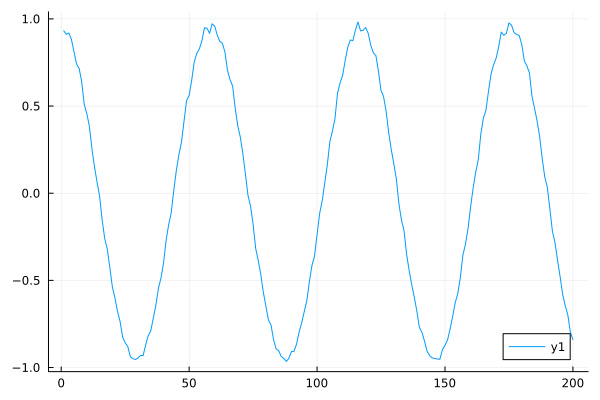

In [301]:
plot(real.(signal))

In [4]:
using Plots
using FFTW
using LaTeXStrings

# plot([real(x[1]) for x in obs.corrs])
signal = [x for x in obs.corrs]
F = fft([conj.(reverse(signal)); 1;signal]) |> fftshift
freqs = fftfreq(length(obs.corrs)*2+1, 1/dt) |> fftshift |> real
time_domain = plot(real.([-reverse(obs.time);0;obs.time]), [real.(signal), imag.(signal)], 
            title = "Signal", xlabel="Time", ylabel="C", label=reshape(["Re","Im"],1,2), xlim=(0,10))
freq_domain = plot(-freqs*2π .+ real.(H_ex), abs.(F), 
            title = "Spectrum", xlabel=L"\omega", ylabel="Amplitude", yscale=:log10, label="TDVP") 
# plot(time_domain, freq_domain, layout = 2)
# plot((-freqs2*2π .+ H_ex), abs.(F2), yscale=:log10, label="Exact")
plot(freq_domain)

# savefig("tmp9.png")


ArgumentError: ArgumentError: Package Plots not found in current path.
- Run `import Pkg; Pkg.add("Plots")` to install the Plots package.

In [ ]:
# (-freqs2*2π)[2] - (-freqs2*2π)[1]
(freqs2*2π)[2] - (freqs2*2π)[1]

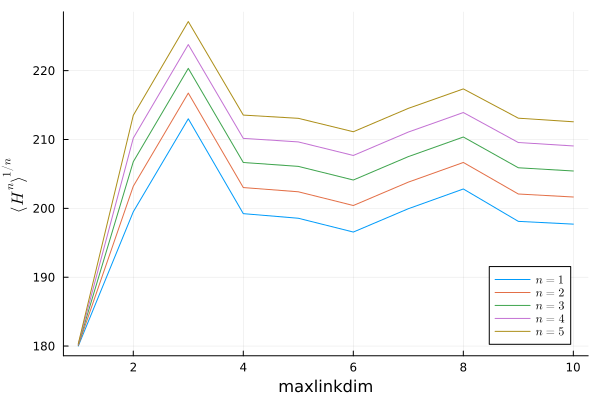

In [29]:
using Plots
using LaTeXStrings
plot(data, xlabel="maxlinkdim", ylabel=L"\langle H^n\rangle^{1/n}", labels=reshape([L"n=%$i" for i in 1:5],1,5))
# savefig("tmp.png")

# Coherence time

In [5]:
function create_Hamiltonian(Nsites, sites;g=1.1)
    Nsecond = zeros(Int64,(Nsites-1))
    for i=1:Nsites-1
        if pairs == "nearest"
            Nsecond[i]=i+1
        elseif pairs == "allpairs"
            Nsecond[i]=Nsites
        end
    end

    ampo = AutoMPO()
    for i=1:Nsites-1
        ampo += 1.0,"T",i
        for j=i+1:Nsecond[i]
            c=g/((abs(j-i))^3)
            if evod == "dvr"
                # y_iy_j#
                ampo += 1.0*c*fac1,"Y",i,"Y",j
                # 2*x_ix_j#
                ampo += -2.0*c,"X",i,"X",j
            else
                # up up
                ampo +=-.75*c,"Up",i,"Up",j
                # up down
                ampo +=-.25*c,"Up",i,"Down",j
                # down up 
                ampo +=-.25*c,"Down",i,"Up",j
                # down down
                ampo +=-.75*c,"Down",i,"Down",j
            end
        end
        #Electric field#
        
        if !iszero(Estrength)
            ampo += -cos(angle)*Estrength,"X",i
            ampo += -sin(angle)*Estrength*fac2,"Y",i
        end
    end
    ampo += 1.0,"T",Nsites
    #Electric field#
    if !iszero(Estrength)
        ampo += -cos(angle)*Estrength,"X",Nsites
        ampo += -sin(angle)*Estrength*fac2,"Y",Nsites
    end
    
    H = MPO(ampo,sites)
    return H
end

create_Hamiltonian (generic function with 1 method)

In [7]:
data_log = []

Any[]

In [8]:
using Printf
using Plots
using LaTeXStrings
using LsqFit

Nsites = 6
split = 3
g = 1.1
linkdims = 50

sweeps = Sweeps(10)
maxdim!(sweeps,linkdims)
setcutoff!(sweeps, 1e-16)

for g = 0.4:0.05:0.6
    sites=siteinds("PlaRotor",Nsites;dim=Nspec, conserve_parity=use_parity_symmetry, conserve_L=false)
    H = create_Hamiltonian(Nsites, sites;g=g)
    psi = randomMPS(sites; linkdims=linkdims)
    # _, psi = dmrg(H, psi, sweeps,outputlevel=0)

    psi[split] = zero(psi[split])
    for i=1:size(psi[split])[1]
        psi[split][i,1,1] = 1
    end
    normalize!(psi)
    @show vN_entropy(psi, split)
    @show inner(psi, psi)

    function return_S(;state)
        return vN_entropy(TTN_to_MPS(state),split)[1:2]
    end

    function overlap(;state)
        return inner(psi, TTN_to_MPS(state))
    end
    obs = observer("S" => return_S)


    tn = MPS_to_ITensorNetwork(psi)
    ttn = ITensorNetworks.TTN(tn)
    Httn = ITensorNetworks.TTN(MPS_to_ITensorNetwork(H))
    psi_f = ITensorNetworks.tdvp(Httn, -20im, ttn; time_step=-1im, (sweep_observer!)=obs,nsites=1)
    H_ex = inner(psi, apply(H, psi))
    push!(data_log, Dict("Nsites"=>Nsites, "split"=>split, "g"=>g, "linkdims"=>linkdims, "H_ex"=>H_ex, "S"=>obs.S))
end

vN_entropy(psi, split) = (3.604762456857383e-29, 1.0, [1.0, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-33, 9.984020831703433e-3

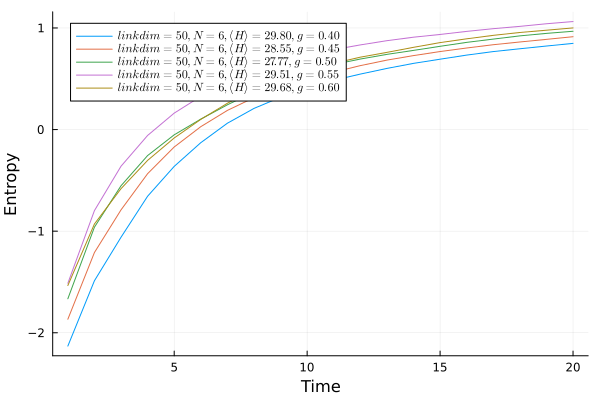

In [30]:
# array(psi[6]) - array(psi_f[6])

p = plot(xlabel="Time", ylabel="Entropy")
for data in data_log
    x = Vector(1:1:20)
    y = hcat(collect.(data["S"])...)[1,:]
    plot!(p, x, log.(y), xlabel="Time", ylabel="Entropy", 
        label=latexstring(@sprintf("linkdim=%d, N=%d, \\langle H\\rangle= %.2f, g=%0.2f",data["linkdims"], data["Nsites"], data["H_ex"], data["g"]))
    )
    # @show length(y) length(x)
end
# savefig(p, "TEST.png")
display(p)

In [40]:
# array(psi[6]) - array(psi_f[6])

func(x,p) = p[1] * exp.(p[2] * x) .+ p[3]
func(x,p) = p[1] * x.^(p[2]) .+ p[3]
p = plot(xlabel="Time", ylabel="Entropy", dpi=300)
for data in data_log
    x = Vector(1:1:20)
    y = hcat(collect.(data["S"])...)[2,:]
    plot!(p, x, y, xlabel="Time", ylabel=L"tr \rho_A^2", 
        label=latexstring(@sprintf("m_{max}=3, linkdim=%d, N=%d, \\langle H\\rangle= %.2f, g=%0.2f",data["linkdims"], data["Nsites"], data["H_ex"], data["g"]))
    )
    p0 = curve_fit(func,x,y,[1.0,-1.0,1.0])
    plot!(p, x, func(x, p0.param), label=string(L"ae^{-bx}+c", " fit"))
end
savefig(p, "exponential_purity.png")
# display(p)

"c:\\Users\\jonat\\OneDrive\\Documents\\programming\\AnacondaProjects\\PHYS437B\\tdvp_project\\tdvp\\exponential_purity.png"

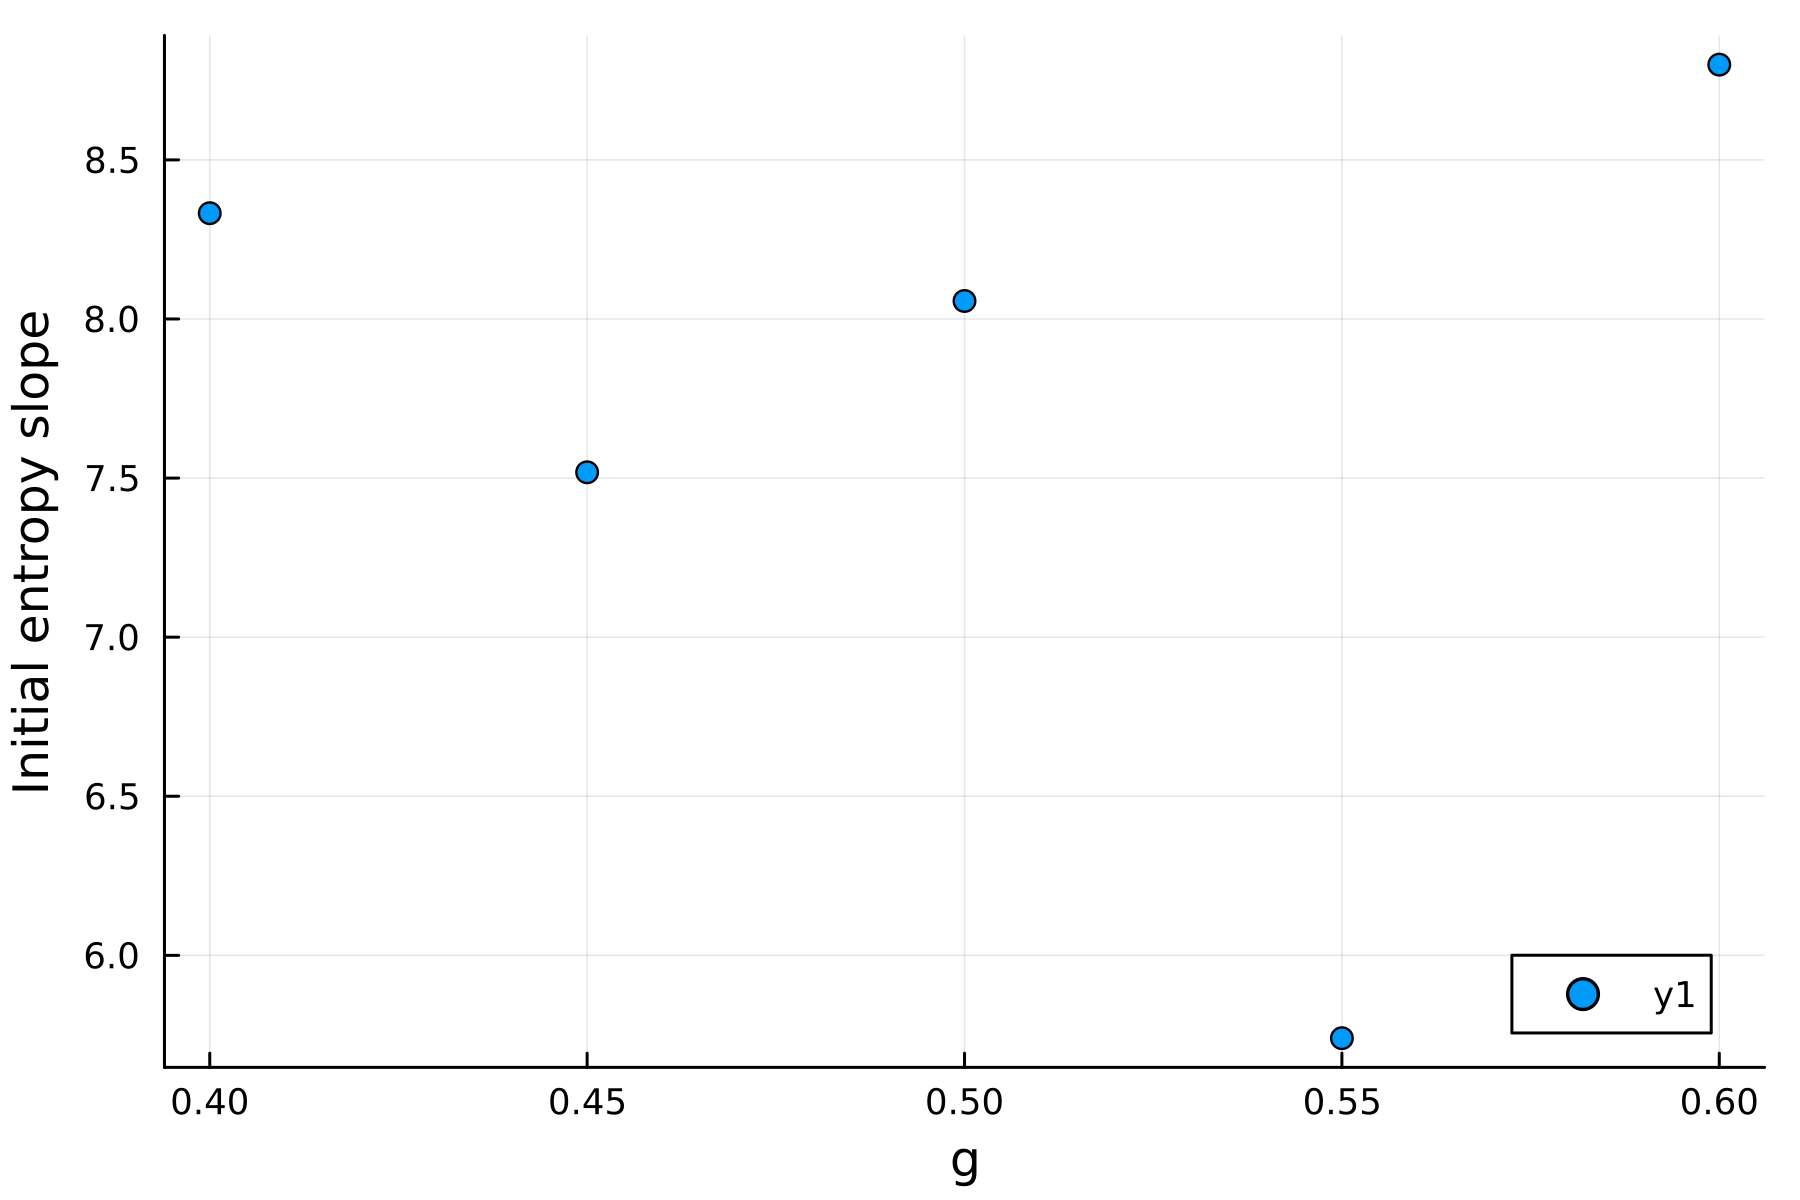

In [42]:
using Polynomials

func(x,p) = p[1] * exp.(-p[2] * x) .+ p[3]
p = plot(xlabel="g", ylabel="Initial entropy slope", dpi=300)
g_values = Float32[]
S_slope = Float32[]
for data in data_log
    x = Vector(1:1:20)
    y = hcat(collect.(data["S"])...)[2,:]
    p0 = curve_fit(func,x,y,[1.0,1.0,1.0])
    if data["H_ex"] >-4
        push!(g_values, data["g"])
        # push!(S_slope, (data["S"][3]-data["S"][1])/2)
        push!(S_slope, 1/p0.param[2])
    end
end
scatter!(p, g_values, S_slope)
# plot!(p,fit(g_values, S_slope, 2), xlim=(0,3.1))
# savefig(p, "coherence_time.png")
# savefig(p, "initial_entropy_slope2.png")
display(p)